<a href="https://colab.research.google.com/github/mlabonne/chess-llm/blob/main/Chess_LLM_Arena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

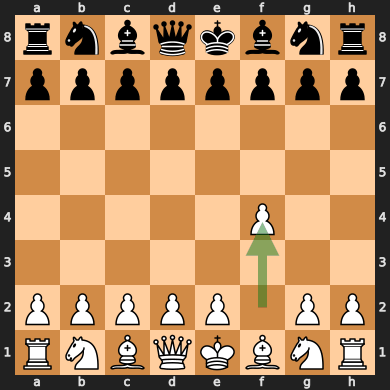

In [ ]:
# @title # ♟️ Chess LLM Arena
# Based on a script made by 903124: https://gist.github.com/903124/cfbefa24da95e2316e0d5e8ef8ed360d
# See in Outlines: https://outlines-dev.github.io/outlines/cookbook/models_playing_chess/

!pip install -qqq python-chess outlines datasets cairosvg --progress-bar off

import io
import os
import re
from datetime import datetime

import cairosvg
import chess
import chess.svg
import imageio
import numpy as np
import outlines.models as models
import outlines.text.generate as generate
from IPython.display import Image as IPythonImage
from IPython.display import clear_output, update_display
from PIL import Image as PILImage


# Generate regular expression for legal moves
def generate_regex(board):
    legal_moves = list(board.legal_moves)
    move_strings = [board.san(move) for move in legal_moves]
    move_strings = [re.sub(r"[+#]", "", move) for move in move_strings]
    regex_pattern = "|".join(re.escape(move) for move in move_strings)
    return regex_pattern


def write_pgn(pgn_moves, model_id_white, model_id_black):
    # Get current UTC date and time
    current_utc_datetime = datetime.utcnow()
    utc_date = current_utc_datetime.strftime("%Y.%m.%d")
    utc_time = current_utc_datetime.strftime("%H:%M:%S")

    # Determine the game result
    if board.is_checkmate():
        result = "1-0" if board.turn == chess.BLACK else "0-1"
    elif board.is_stalemate() or board.is_insufficient_material():
        result = "1/2-1/2"
    else:
        result = "*"

    # Output the final PGN with CLKS and additional details
    final_pgn = f"""[Event 'Chess LLM Arena']
    [Date '{utc_date}']
    [White '{model_id_white}']
    [Black '{model_id_black}']
    [Result '{result}']
    [UTCDate '{utc_date}']
    [UTCTime '{utc_time}']

    {pgn_moves}"""

    return final_pgn


# Create a GIF from a list of images
def create_gif(image_list, gif_path, duration):
    with imageio.get_writer(gif_path, mode="I", duration=duration) as writer:
        for image in image_list:
            writer.append_data(image)


os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Initialize model
# @markdown ## Models
model_id_white = "mlabonne/chesspythia-70m"  # @param {type: "string"}
model_id_black = "EleutherAI/pythia-70m"  # @param {type: "string"}
model_white = models.transformers(model_id_white)
model_black = models.transformers(model_id_black)

# @markdown ## Optional parameters
prompt = '[Result "0-0"]\\n[WhiteElo "1800"]\\n[BlackElo "1800"]\\n'  # @param {type: "string"}
MAX_MOVES = 0 # @param {type: "number"}
if MAX_MOVES <= 0:
    MAX_MOVES = 999_999

# Initialize the chess board
board = chess.Board()
board_images = []
pgn_moves = ""
move_number = 1

# Game loop
while not board.is_game_over() and move_number <= MAX_MOVES:
    # Generate move
    regex_pattern = generate_regex(board)
    current_model = model_white if board.turn == chess.WHITE else model_black
    guided = generate.regex(current_model, regex_pattern, max_tokens=10)(prompt)

    try:
        # Parse move
        move_san = guided.strip()
        move = board.parse_san(move_san)
        if move not in board.legal_moves:
            print(f"Illegal move: {move_san}")
            break
        board.push(move)

        # Write move
        if board.turn == chess.BLACK:
            move_str = f"{move_number}. {move_san} "
            move_number += 1
        else:
            move_str = f"{move_san} "
        pgn_moves += move_str

        # Render the board to an image
        last_move = board.peek()  # Get the last move made
        svg = chess.svg.board(
            board=board, arrows=[(last_move.from_square, last_move.to_square)]
        ).encode("utf-8")
        png = cairosvg.svg2png(bytestring=svg)
        image = PILImage.open(io.BytesIO(png))
        board_images.append(np.array(image))

        # Display board
        update_display(image, display_id="chess_board")

    except ValueError:
        print(f"Invalid move: {guided}")
        break

final_pgn = write_pgn(pgn_moves, model_id_white, model_id_black)

# Create and display the GIF
clear_output(wait=True)
file_name = f"{model_id_white.split('/')[-1]}_vs_{model_id_black.split('/')[-1]}.gif"
create_gif(board_images, file_name, duration=400)
IPythonImage(filename=file_name)